In [84]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [37]:
def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100
mape_scorer = make_scorer(mape, greater_is_better = False)

## Load Data

In [93]:
train = pd.read_csv("../data/training_set.csv")
train_y = np.ravel(train.groupby(by = ["Game_ID"]).sum().values)
train = train.drop(["Country", "Rounded Viewers", "Game_ID"], axis = 1)
test = pd.read_csv("../data/test_set.csv").drop("Total_Viewers", axis = 1)
ids = test.pop("Game_ID")
game_data = pd.read_csv("../data/game_data.csv")
player_data = pd.read_csv("../data/player_data.csv")

In [69]:
display(player_data.loc[player_data.Game_Date == "10/26/2016"])

,Season,Game_ID,Game_Date,Team,Person_ID,Name,ASG_Team,Active_Status,Minutes,Points,...,Steals,Blocks,Turnovers,Field_Goals,Field_Goals_Attempted,Three_Pointers,Three_Pointers_Attempted,Free_Throws,Free_Throws_Attempted,Personal_Fouls
90,2016-17,21600004,10/26/2016,MIA,2547,Chris Bosh,None,Inactive,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,2016-17,21600004,10/26/2016,MIA,2617,Udonis Haslem,None,Active,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,2016-17,21600004,10/26/2016,MIA,201177,Josh McRoberts,None,Active,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,2016-17,21600004,10/26/2016,MIA,201609,Goran Dragic,None,Active,29.0,16.0,...,0.0,0.0,3.0,7.0,15.0,0.0,1.0,2.0,2.0,4.0
94,2016-17,21600004,10/26/2016,MIA,201961,Wayne Ellington,None,Inactive,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,2016-17,21600004,10/26/2016,MIA,201949,James Johnson,None,Active,25.0,11.0,...,0.0,0.0,1.0,4.0,8.0,2.0,4.0,1.0,1.0,1.0
96,2016-17,21600004,10/26/2016,MIA,203079,Dion Waiters,None,Active,34.0,9.0,...,0.0,0.0,1.0,4.0,13.0,0.0,1.0,1.0,2.0,2.0
97,2016-17,21600004,10/26/2016,MIA,202355,Hassan Whiteside,None,Active,31.0,18.0,...,0.0,4.0,1.0,9.0,16.0,0.0,0.0,0.0,4.0,3.0
98,2016-17,21600004,10/26/2016,MIA,202337,Luke Babbitt,None,Active,19.0,8.0,...,0.0,0.0,0.0,3.0,10.0,2.0,6.0,0.0,0.0,1.0
99,2016-17,21600004,10/26/2016,MIA,1626196,Josh Richardson,None,Active,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocess

In [94]:
for column in ["Away_Team", "Home_Team"]:
    train[column] = train[column].astype('category')

t1 = train.drop_duplicates().reset_index().drop("index", axis = 1)
t2 = pd.get_dummies(t1, columns = ["Away_Team", "Home_Team"])
season_encoder = LabelEncoder()
date_encoder = LabelEncoder()
t2["Season"] = season_encoder.fit_transform(t2["Season"])
t2["Game_Date"] = date_encoder.fit_transform(t2["Game_Date"])
test["Season"] = season_encoder.transform(test["Season"])
test["Game_Date"] = date_encoder.transform(test["Game_Date"])
test = pd.get_dummies(test, columns = ["Away_Team", "Home_Team"])

Fitting 3 folds for each of 195 candidates, totalling 585 fits


[Parallel(n_jobs=1)]: Done 585 out of 585 | elapsed:  7.0min finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.7min finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   20.1s finished
c:\users\david rein\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


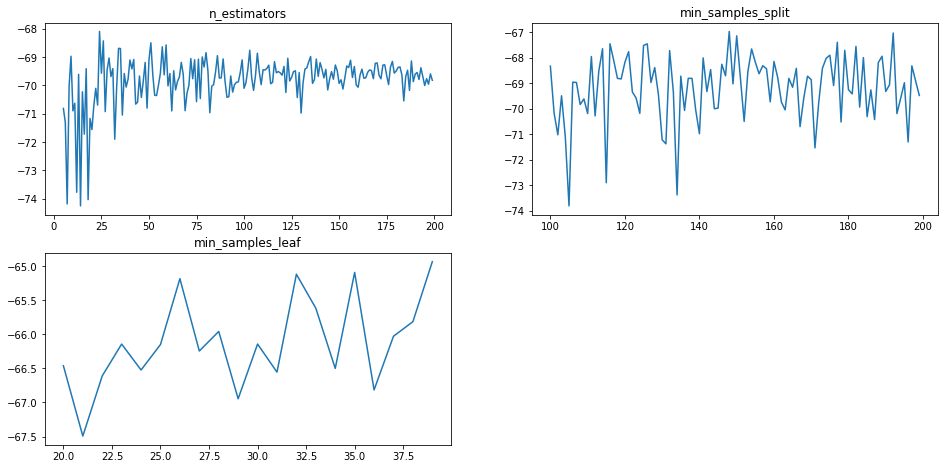

In [47]:
model = RandomForestRegressor(n_jobs = 4)

# function takes a RF parameter and a ranger and produces a plot and dataframe of CV scores for parameter values
def evaluate_param(parameter, num_range, index):
    grid_search = GridSearchCV(model, param_grid = {parameter: num_range}, scoring = mape_scorer, verbose = 1)
    grid_search.fit(t2, train_y)
    
    df = {}
    for i, score in enumerate(grid_search.grid_scores_):
        df[score[0][parameter]] = score[1]
       
    
    df = pd.DataFrame.from_dict(df, orient='index')
    df.reset_index(level=0, inplace=True)
    df = df.sort_values(by='index')
 
    plt.subplot(3,2,index)
    plot = plt.plot(df['index'], df[0])
    plt.title(parameter)
    return plot, df

# parameters and ranges to plot
param_grid = {"n_estimators"     : np.arange(5, 200, 1),
              "min_samples_split": np.arange(100, 200, 1),
              "min_samples_leaf" : np.arange(20, 40, 1)}

# min_samples_leaf -> 20-40
# min_samples_split -> 100-200


index = 1
plt.figure(figsize=(16,12))
for parameter, param_range in dict.items(param_grid):   
    evaluate_param(parameter, param_range, index)
    index += 1

In [101]:
%%time
model = RandomForestRegressor(n_jobs = 4)

params = {'max_depth'        : [None],
          'criterion'        : ['mae'],
          'min_samples_leaf' : [30],
          'min_samples_split': [100],
          'n_estimators'     : [40, 50, 60, 70, 80, 90]}
grid_search = GridSearchCV(estimator = model, cv = 5, verbose = 1, 
                           param_grid = params, scoring = mape_scorer, 
                           return_train_score = True, refit = True)
grid_search.fit(X = t2, y = train_y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.1min finished


Wall time: 1min 9s


In [100]:
grid_search.best_params_

{'criterion': 'mae',
 'max_depth': None,
 'min_samples_leaf': 30,
 'min_samples_split': 100,
 'n_estimators': 60}

In [102]:
grid_search.predict(test)

array([ 24103.7125 ,  24274.8625 ,  24171.55   ,  24171.55   ,
        21790.99375,  21790.99375,  21790.99375,  21790.99375,
        17133.5625 ,  17133.5625 ,  14795.88125,  14795.88125,
        17683.7875 ,  18464.8125 ,  18599.51875,  18599.51875,
        18545.475  ,  18545.475  ,  20335.3875 ,  20266.9625 ,
        19103.6875 ,  19103.6875 ,  19103.6875 ,  19103.6875 ,
        19103.6875 ,  19031.8875 ,  17303.43125,  17303.43125,
        17303.43125,  16977.29375,  16977.29375,  16977.29375,
        16787.20625,  16729.03125,  16729.03125,  16838.10625,
        17116.6375 ,  17020.90625,  17020.90625,  17020.90625,
        16003.225  ,  16003.225  ,  15832.50625,  15797.94375,
        14981.6625 ,  14981.6625 ,  14515.4375 ,  17912.49375,
        12175.8    ,  12632.1375 ,  12632.1375 ,  12632.1375 ,
        12632.1375 ,  15135.225  ,  15135.225  ,  15135.225  ,
        15135.225  ,  15309.05625,  15467.53125,  15719.875  ,
        17709.0125 ,  17709.0125 ,  17709.0125 ,  16740

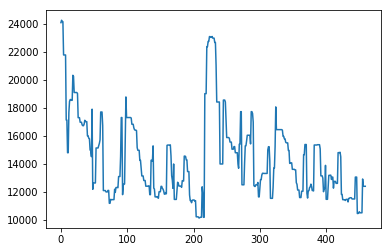

In [103]:
import matplotlib.pyplot as plt
plt.plot(grid_search.predict(test))
plt.show()